# Inception model explanations, t5

## First we need dataframes for every subject

In [2]:
import sys
sys.path.append('../')
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np
import utils
import keras

%matplotlib inline

# DEFINE GRAPH
from importlib import reload
reload(utils)

pd.set_option('max_colwidth', 800) 

Using TensorFlow backend.


In [4]:
# Data paths
rgb_path = '../data/jpg_320_180_2fps/'
of_path = 'no'

# Hyperparameters
input_width = 320
input_height = 180
seq_length = 10
seq_stride = 1
batch_size = 10
COLOR = True
nb_labels = 2

# Data augmentation
aug_flip = 0
aug_crop = 0
aug_light = 0

nb_input_dims = 4

subject_ids = pd.read_csv('../metadata/horse_subjects.csv')['Subject'].values
channels = 3

In [5]:
from utils import ArgsProxy
args = ArgsProxy(rgb_path, of_path, input_height, input_width,
                 seq_length, seq_stride, batch_size, nb_labels,
                 aug_flip, aug_crop, aug_light, nb_input_dims)

In [6]:
import data_handler as dathand
dh = dathand.DataHandler(path=args.data_path,
                         of_path=args.of_path,
                         clip_list_file='videos_overview_missingremoved.csv',
                         data_columns=['Pain'],  # Here one can append f. ex. 'Observer'
                         image_size=(args.input_height, args.input_width),
                         seq_length=args.seq_length,
                         seq_stride=args.seq_stride,
                         batch_size=args.batch_size,
                         color=COLOR,
                         nb_labels=args.nb_labels,
                         aug_flip=args.aug_flip,
                         aug_crop=args.aug_crop,
                         aug_light=args.aug_light,
                         nb_input_dims=args.nb_input_dims)

In [7]:
import utils
subject_dfs = utils.read_or_create_subject_dfs(dh, args, subject_ids)

../data/jpg_320_180_2fps/
../data/jpg_320_180_2fps/
../data/jpg_320_180_2fps/
../data/jpg_320_180_2fps/
../data/jpg_320_180_2fps/
../data/jpg_320_180_2fps/


## Now that we have frames from all subjects, we can load the model we want to test.

In [8]:
# Choose a model to work on
best_model_path = '../models/BEST_MODEL_inception_4d_input_from_scratch_rmsprop_LSTMunits_None_CONVfilters_None_dense512_320x180jpg2fps_bs100_rmsprop_all_aug_v4_t5_run1_gc_rerun.h5'


In [9]:
from keras import backend as K
import tensorflow as tf

tf.reset_default_graph()
K.clear_session()
    
images = tf.placeholder(tf.float32, [batch_size, args.input_width, args.input_height, channels])
labels = tf.placeholder(tf.float32, [batch_size, 2])

model = utils.InceptionNetwork(images, from_scratch=0, path=best_model_path)

Loading model...
Finished loading model. Building layers...


In [10]:
sess = K.get_session()  # Grab the Keras session where the weights are initialized.

print('model preds: ', model.preds)

cost = (-1) * tf.reduce_sum(tf.multiply(labels, tf.log(model.preds)), axis=1)

print('cost: ', cost)

y_c = tf.reduce_sum(tf.multiply(model.dense_2, labels), axis=1)

print('y_c: ', y_c)


# target_conv_layer = model.c_86  # Choose which layer to study
target_conv_layer = model.c_94  # Here: last conv.
# target_conv_layer = model.mixed10 

print('TYPE tcl: ', type(target_conv_layer))
print('tcl: ', target_conv_layer)

target_conv_layer_grad = tf.gradients(y_c, target_conv_layer)[0]

print('tcl grad: ', target_conv_layer_grad)
print('tclg: ', target_conv_layer_grad)
    
gb_grad = tf.gradients(cost, images)[0]  # Guided backpropagation back to input layer

model preds:  Tensor("activation_95_1/Sigmoid:0", shape=(10, 2), dtype=float32)
cost:  Tensor("mul_1:0", shape=(10,), dtype=float32)
y_c:  Tensor("Sum_1:0", shape=(10,), dtype=float32)
TYPE tcl:  <class 'tensorflow.python.framework.ops.Tensor'>
tcl:  Tensor("conv2d_94_1/convolution:0", shape=(10, 8, 4, 192), dtype=float32)
tcl grad:  Tensor("gradients/AddN:0", shape=(10, 8, 4, 192), dtype=float32)
tclg:  Tensor("gradients/AddN:0", shape=(10, 8, 4, 192), dtype=float32)


In [11]:
def run_on_one_sequence(sess, model, batch_img, args):
    with sess.as_default():
        prob = sess.run(model.preds,
                        feed_dict={images: batch_img,
                                   K.learning_phase(): 0})

        print(prob)
        
        gb_grad_value, target_conv_layer_value, target_conv_layer_grad_value = sess.run([gb_grad, target_conv_layer, target_conv_layer_grad],
              feed_dict={images: batch_img,
              labels: batch_label,
              K.learning_phase(): 0})

#         print('tcl: ')
#         print(target_conv_layer_value)
#         print('')
#         print('tclg: ')
#         print(target_conv_layer_grad_value)
        
        utils.visualize_overlays(batch_img, target_conv_layer_value,
                                 target_conv_layer_grad_value, args)

# Inception predictions for subject t5

Chose subject  5
Start index in subject dataframe:  6358
                                                    Path  Pain
0  data/jpg_320_180_2fps/horse_6/6_6a_2/frame_000065.jpg     1
1  data/jpg_320_180_2fps/horse_6/6_6a_2/frame_000066.jpg     1
2  data/jpg_320_180_2fps/horse_6/6_6a_2/frame_000067.jpg     1
3  data/jpg_320_180_2fps/horse_6/6_6a_2/frame_000068.jpg     1
4  data/jpg_320_180_2fps/horse_6/6_6a_2/frame_000069.jpg     1
5  data/jpg_320_180_2fps/horse_6/6_6a_2/frame_000070.jpg     1
6  data/jpg_320_180_2fps/horse_6/6_6a_2/frame_000071.jpg     1
7  data/jpg_320_180_2fps/horse_6/6_6a_2/frame_000072.jpg     1
8  data/jpg_320_180_2fps/horse_6/6_6a_2/frame_000073.jpg     1
9  data/jpg_320_180_2fps/horse_6/6_6a_2/frame_000074.jpg     1
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


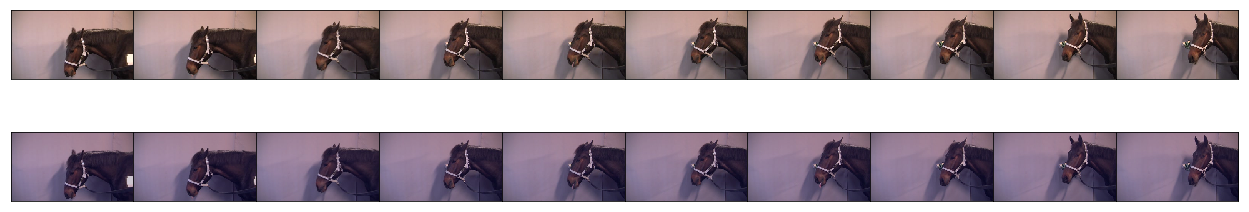

In [12]:
batch_img, batch_label = utils.data_for_one_random_sequence_4D(args, subject_dfs, computer='local', subject=5)
batch_img = np.array(batch_img, dtype=np.float32)

batch_label = np.array(batch_label, dtype=np.uint8)
run_on_one_sequence(sess, model, batch_img, args)

Chose subject  5
Start index in subject dataframe:  2011
                                                  Path  Pain
0  data/jpg_320_180_2fps/horse_6/6_2b/frame_000012.jpg     0
1  data/jpg_320_180_2fps/horse_6/6_2b/frame_000013.jpg     0
2  data/jpg_320_180_2fps/horse_6/6_2b/frame_000014.jpg     0
3  data/jpg_320_180_2fps/horse_6/6_2b/frame_000015.jpg     0
4  data/jpg_320_180_2fps/horse_6/6_2b/frame_000016.jpg     0
5  data/jpg_320_180_2fps/horse_6/6_2b/frame_000017.jpg     0
6  data/jpg_320_180_2fps/horse_6/6_2b/frame_000018.jpg     0
7  data/jpg_320_180_2fps/horse_6/6_2b/frame_000019.jpg     0
8  data/jpg_320_180_2fps/horse_6/6_2b/frame_000020.jpg     0
9  data/jpg_320_180_2fps/horse_6/6_2b/frame_000021.jpg     0
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


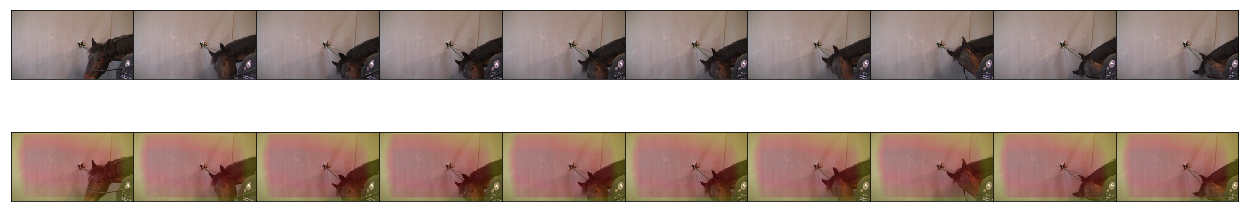

In [13]:
batch_img, batch_label = utils.data_for_one_random_sequence_4D(args, subject_dfs, computer='local', subject=5)
batch_img = np.array(batch_img, dtype=np.float32)

batch_label = np.array(batch_label, dtype=np.uint8)
run_on_one_sequence(sess, model, batch_img, args)

Chose subject  5
Start index in subject dataframe:  747
                                                  Path  Pain
0  data/jpg_320_180_2fps/horse_6/6_2a/frame_000748.jpg     0
1  data/jpg_320_180_2fps/horse_6/6_2a/frame_000749.jpg     0
2  data/jpg_320_180_2fps/horse_6/6_2a/frame_000750.jpg     0
3  data/jpg_320_180_2fps/horse_6/6_2a/frame_000751.jpg     0
4  data/jpg_320_180_2fps/horse_6/6_2a/frame_000752.jpg     0
5  data/jpg_320_180_2fps/horse_6/6_2a/frame_000753.jpg     0
6  data/jpg_320_180_2fps/horse_6/6_2a/frame_000754.jpg     0
7  data/jpg_320_180_2fps/horse_6/6_2a/frame_000755.jpg     0
8  data/jpg_320_180_2fps/horse_6/6_2a/frame_000756.jpg     0
9  data/jpg_320_180_2fps/horse_6/6_2a/frame_000757.jpg     0
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


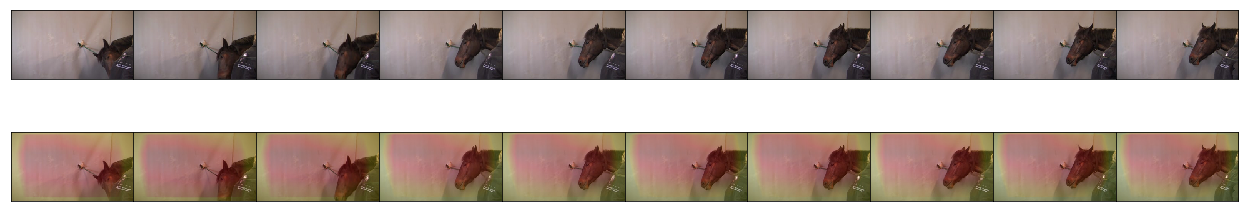

In [14]:
batch_img, batch_label = utils.data_for_one_random_sequence_4D(args, subject_dfs, computer='local', subject=5)
batch_img = np.array(batch_img, dtype=np.float32)

batch_label = np.array(batch_label, dtype=np.uint8)
run_on_one_sequence(sess, model, batch_img, args)

Chose subject  5
Start index in subject dataframe:  1087
                                                  Path  Pain
0  data/jpg_320_180_2fps/horse_6/6_2a/frame_001088.jpg     0
1  data/jpg_320_180_2fps/horse_6/6_2a/frame_001089.jpg     0
2  data/jpg_320_180_2fps/horse_6/6_2a/frame_001090.jpg     0
3  data/jpg_320_180_2fps/horse_6/6_2a/frame_001091.jpg     0
4  data/jpg_320_180_2fps/horse_6/6_2a/frame_001092.jpg     0
5  data/jpg_320_180_2fps/horse_6/6_2a/frame_001093.jpg     0
6  data/jpg_320_180_2fps/horse_6/6_2a/frame_001094.jpg     0
7  data/jpg_320_180_2fps/horse_6/6_2a/frame_001095.jpg     0
8  data/jpg_320_180_2fps/horse_6/6_2a/frame_001096.jpg     0
9  data/jpg_320_180_2fps/horse_6/6_2a/frame_001097.jpg     0
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


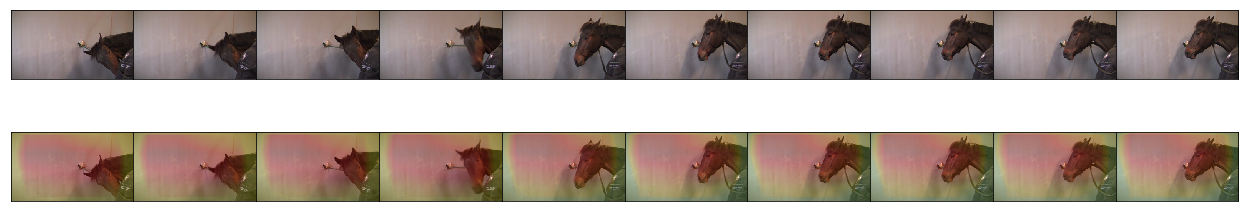

In [15]:
batch_img, batch_label = utils.data_for_one_random_sequence_4D(args, subject_dfs, computer='local', subject=5)
batch_img = np.array(batch_img, dtype=np.float32)

batch_label = np.array(batch_label, dtype=np.uint8)
run_on_one_sequence(sess, model, batch_img, args)

Chose subject  5
Start index in subject dataframe:  3868
                                                  Path  Pain
0  data/jpg_320_180_2fps/horse_6/6_4a/frame_000315.jpg     1
1  data/jpg_320_180_2fps/horse_6/6_4a/frame_000316.jpg     1
2  data/jpg_320_180_2fps/horse_6/6_4a/frame_000317.jpg     1
3  data/jpg_320_180_2fps/horse_6/6_4a/frame_000318.jpg     1
4  data/jpg_320_180_2fps/horse_6/6_4a/frame_000319.jpg     1
5  data/jpg_320_180_2fps/horse_6/6_4a/frame_000320.jpg     1
6  data/jpg_320_180_2fps/horse_6/6_4a/frame_000321.jpg     1
7  data/jpg_320_180_2fps/horse_6/6_4a/frame_000322.jpg     1
8  data/jpg_320_180_2fps/horse_6/6_4a/frame_000323.jpg     1
9  data/jpg_320_180_2fps/horse_6/6_4a/frame_000324.jpg     1
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


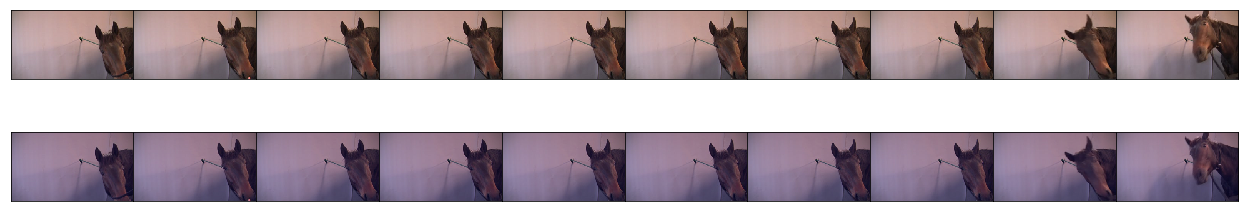

In [16]:
batch_img, batch_label = utils.data_for_one_random_sequence_4D(args, subject_dfs, computer='local', subject=5)
batch_img = np.array(batch_img, dtype=np.float32)

batch_label = np.array(batch_label, dtype=np.uint8)
run_on_one_sequence(sess, model, batch_img, args)

Chose subject  5
Start index in subject dataframe:  5862
                                                    Path  Pain
0  data/jpg_320_180_2fps/horse_6/6_6a_1/frame_000469.jpg     1
1  data/jpg_320_180_2fps/horse_6/6_6a_1/frame_000470.jpg     1
2  data/jpg_320_180_2fps/horse_6/6_6a_1/frame_000471.jpg     1
3  data/jpg_320_180_2fps/horse_6/6_6a_1/frame_000472.jpg     1
4  data/jpg_320_180_2fps/horse_6/6_6a_1/frame_000473.jpg     1
5  data/jpg_320_180_2fps/horse_6/6_6a_1/frame_000474.jpg     1
6  data/jpg_320_180_2fps/horse_6/6_6a_1/frame_000475.jpg     1
7  data/jpg_320_180_2fps/horse_6/6_6a_1/frame_000476.jpg     1
8  data/jpg_320_180_2fps/horse_6/6_6a_1/frame_000477.jpg     1
9  data/jpg_320_180_2fps/horse_6/6_6a_1/frame_000478.jpg     1
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


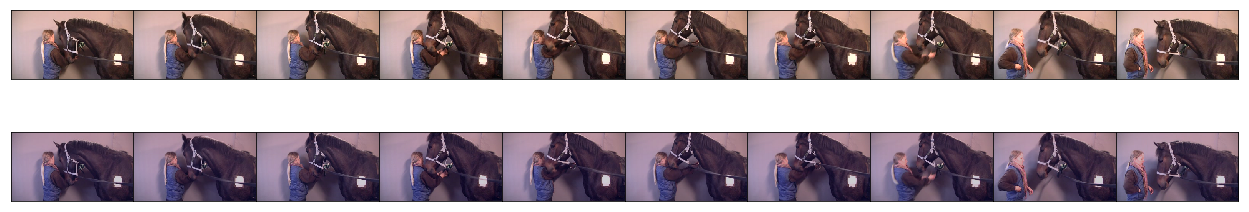

In [17]:
batch_img, batch_label = utils.data_for_one_random_sequence_4D(args, subject_dfs, computer='local', subject=5)
batch_img = np.array(batch_img, dtype=np.float32)

batch_label = np.array(batch_label, dtype=np.uint8)
run_on_one_sequence(sess, model, batch_img, args)

Chose subject  5
Start index in subject dataframe:  6230
                                                    Path  Pain
0  data/jpg_320_180_2fps/horse_6/6_6a_1/frame_000837.jpg     1
1  data/jpg_320_180_2fps/horse_6/6_6a_1/frame_000838.jpg     1
2  data/jpg_320_180_2fps/horse_6/6_6a_1/frame_000839.jpg     1
3  data/jpg_320_180_2fps/horse_6/6_6a_1/frame_000840.jpg     1
4  data/jpg_320_180_2fps/horse_6/6_6a_1/frame_000841.jpg     1
5  data/jpg_320_180_2fps/horse_6/6_6a_1/frame_000842.jpg     1
6  data/jpg_320_180_2fps/horse_6/6_6a_1/frame_000843.jpg     1
7  data/jpg_320_180_2fps/horse_6/6_6a_1/frame_000844.jpg     1
8  data/jpg_320_180_2fps/horse_6/6_6a_1/frame_000845.jpg     1
9  data/jpg_320_180_2fps/horse_6/6_6a_1/frame_000846.jpg     1
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


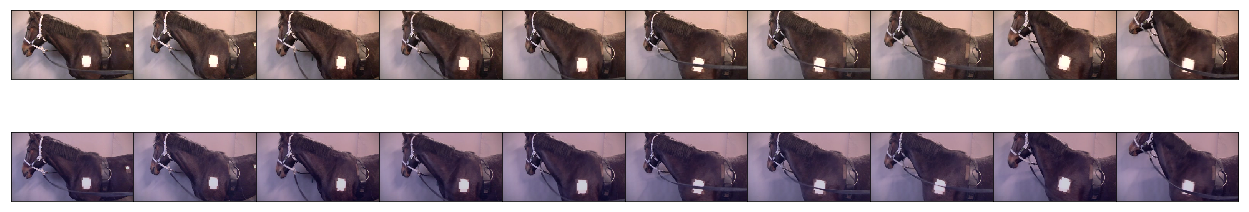

In [18]:
batch_img, batch_label = utils.data_for_one_random_sequence_4D(args, subject_dfs, computer='local', subject=5)
batch_img = np.array(batch_img, dtype=np.float32)

batch_label = np.array(batch_label, dtype=np.uint8)
run_on_one_sequence(sess, model, batch_img, args)

Chose subject  5
Start index in subject dataframe:  5394
                                                    Path  Pain
0  data/jpg_320_180_2fps/horse_6/6_6a_1/frame_000001.jpg     1
1  data/jpg_320_180_2fps/horse_6/6_6a_1/frame_000002.jpg     1
2  data/jpg_320_180_2fps/horse_6/6_6a_1/frame_000003.jpg     1
3  data/jpg_320_180_2fps/horse_6/6_6a_1/frame_000004.jpg     1
4  data/jpg_320_180_2fps/horse_6/6_6a_1/frame_000005.jpg     1
5  data/jpg_320_180_2fps/horse_6/6_6a_1/frame_000006.jpg     1
6  data/jpg_320_180_2fps/horse_6/6_6a_1/frame_000007.jpg     1
7  data/jpg_320_180_2fps/horse_6/6_6a_1/frame_000008.jpg     1
8  data/jpg_320_180_2fps/horse_6/6_6a_1/frame_000009.jpg     1
9  data/jpg_320_180_2fps/horse_6/6_6a_1/frame_000010.jpg     1
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


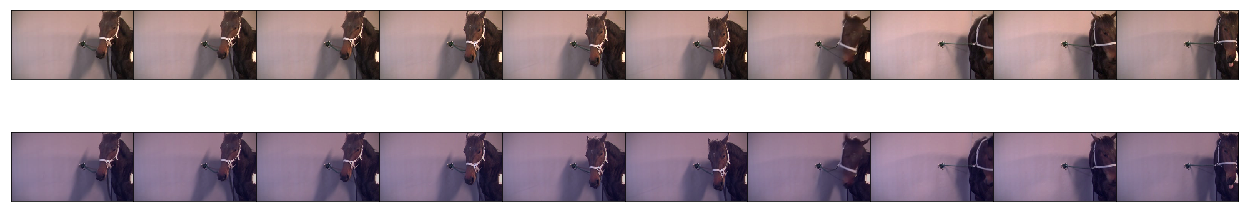

In [19]:
batch_img, batch_label = utils.data_for_one_random_sequence_4D(args, subject_dfs, computer='local', subject=5)
batch_img = np.array(batch_img, dtype=np.float32)

batch_label = np.array(batch_label, dtype=np.uint8)
run_on_one_sequence(sess, model, batch_img, args)

Chose subject  5
Start index in subject dataframe:  748
                                                  Path  Pain
0  data/jpg_320_180_2fps/horse_6/6_2a/frame_000749.jpg     0
1  data/jpg_320_180_2fps/horse_6/6_2a/frame_000750.jpg     0
2  data/jpg_320_180_2fps/horse_6/6_2a/frame_000751.jpg     0
3  data/jpg_320_180_2fps/horse_6/6_2a/frame_000752.jpg     0
4  data/jpg_320_180_2fps/horse_6/6_2a/frame_000753.jpg     0
5  data/jpg_320_180_2fps/horse_6/6_2a/frame_000754.jpg     0
6  data/jpg_320_180_2fps/horse_6/6_2a/frame_000755.jpg     0
7  data/jpg_320_180_2fps/horse_6/6_2a/frame_000756.jpg     0
8  data/jpg_320_180_2fps/horse_6/6_2a/frame_000757.jpg     0
9  data/jpg_320_180_2fps/horse_6/6_2a/frame_000758.jpg     0
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


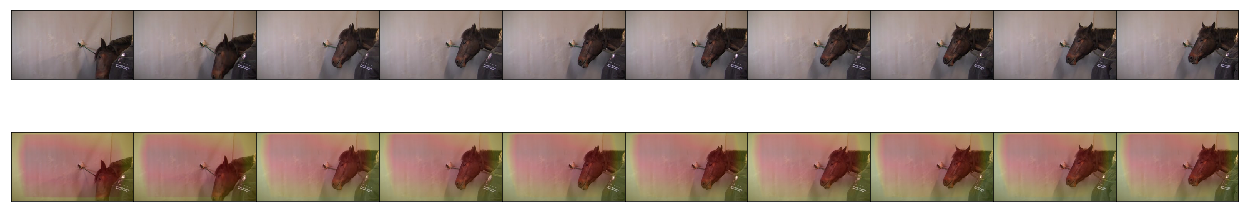

In [20]:
batch_img, batch_label = utils.data_for_one_random_sequence_4D(args, subject_dfs, computer='local', subject=5)
batch_img = np.array(batch_img, dtype=np.float32)

batch_label = np.array(batch_label, dtype=np.uint8)
run_on_one_sequence(sess, model, batch_img, args)

Chose subject  5
Start index in subject dataframe:  1448
                                                  Path  Pain
0  data/jpg_320_180_2fps/horse_6/6_2a/frame_001449.jpg     0
1  data/jpg_320_180_2fps/horse_6/6_2a/frame_001450.jpg     0
2  data/jpg_320_180_2fps/horse_6/6_2a/frame_001451.jpg     0
3  data/jpg_320_180_2fps/horse_6/6_2a/frame_001452.jpg     0
4  data/jpg_320_180_2fps/horse_6/6_2a/frame_001453.jpg     0
5  data/jpg_320_180_2fps/horse_6/6_2a/frame_001454.jpg     0
6  data/jpg_320_180_2fps/horse_6/6_2a/frame_001455.jpg     0
7  data/jpg_320_180_2fps/horse_6/6_2a/frame_001456.jpg     0
8  data/jpg_320_180_2fps/horse_6/6_2a/frame_001457.jpg     0
9  data/jpg_320_180_2fps/horse_6/6_2a/frame_001458.jpg     0
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


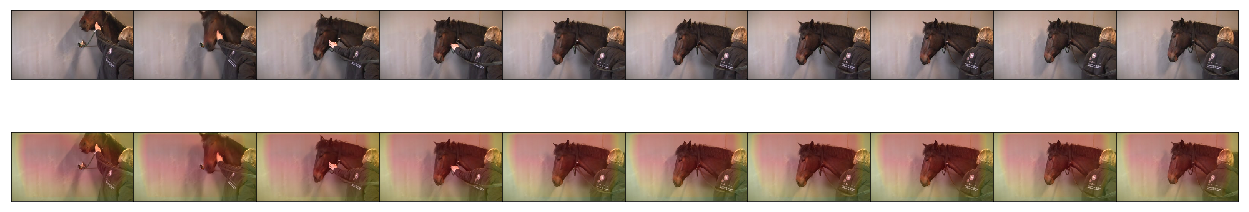

In [21]:
batch_img, batch_label = utils.data_for_one_random_sequence_4D(args, subject_dfs, computer='local', subject=5)
batch_img = np.array(batch_img, dtype=np.float32)

batch_label = np.array(batch_label, dtype=np.uint8)
run_on_one_sequence(sess, model, batch_img, args)